In [1]:
import os
import cv2
import torch
import gdown
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from cv2.ximgproc import guidedFilter
from blurgenerator import lens_blur_with_depth_map
from transformers import AutoImageProcessor, AutoModelForDepthEstimation

ImportError: dlopen(/Users/hasibulhasan/miniforge3/envs/torch/lib/python3.8/site-packages/torch/_C.cpython-38-darwin.so, 0x0002): Library not loaded: @rpath/libtorch_cpu.dylib
  Referenced from: <3CBD18D6-9E8A-3692-9FA8-C3F7435D9B3D> /Users/hasibulhasan/miniforge3/envs/torch/lib/python3.8/site-packages/torch/lib/libtorch_python.dylib
  Reason: tried: '/Users/hasibulhasan/miniforge3/envs/torch/lib/python3.8/site-packages/torch/lib/libtorch_cpu.dylib' (no such file), '/Users/hasibulhasan/miniforge3/envs/torch/lib/python3.8/site-packages/torch/lib/libtorch_cpu.dylib' (no such file), '/Users/hasibulhasan/miniforge3/envs/torch/lib/python3.8/site-packages/torch/lib/libtorch_cpu.dylib' (no such file), '/Users/hasibulhasan/miniforge3/envs/torch/bin/../lib/libtorch_cpu.dylib' (no such file), '/Users/hasibulhasan/miniforge3/envs/torch/bin/../lib/libtorch_cpu.dylib' (no such file), '/usr/local/lib/libtorch_cpu.dylib' (no such file), '/usr/lib/libtorch_cpu.dylib' (no such file, not in dyld cache)

In [34]:
#DEVIDE AGNOSTIC CODE
if torch.cuda.is_available():
    device = torch.device("cuda")
# elif torch.backends.mps.is_available():
#     device = torch.device("mps")
else: 
    device = torch.device("cpu")

print('device:', device)

device: cpu


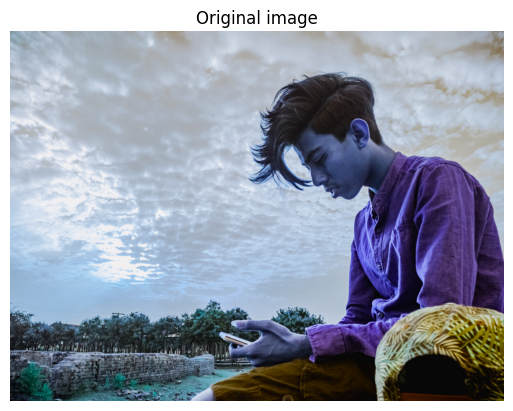

In [35]:
path = "test_images/IMG_20200311_171140.jpg"
image = cv2.imread(path)
image_data = np.copy(image)
plt.imshow(image_data)
plt.title('Original image')
plt.axis('off')  # Hide the axis
plt.show()

In [36]:
def create_model_directory(base_path):
    model_path = os.path.join(base_path, "model")
    if not os.path.exists(model_path):
        os.makedirs(model_path)
        print(f"Directory 'model' created at: {model_path}")
        processor = AutoImageProcessor.from_pretrained("LiheYoung/depth-anything-large-hf")
        model = AutoModelForDepthEstimation.from_pretrained("LiheYoung/depth-anything-large-hf")
        processor.save_pretrained(model_path)
        model.save_pretrained(model_path)
    else:
        print(f"Directory 'model' already exists at: {model_path}")
    return model_path
root_path = os.getcwd()
model_path = create_model_directory(root_path)
print(f"New directory path: {model_path}")

Directory 'model' already exists at: /Users/hasibulhasan/pytorch/github/depth_blur/model
New directory path: /Users/hasibulhasan/pytorch/github/depth_blur/model


In [37]:

# url = "https://drive.google.com/drive/folders/12mN30g2wdvffbaWgOwu6BZcDGeBfe82e?usp=drive_link"
# weights_path = os.path.join(root_path, "weights")
# if url.split('/')[-1] == '?usp=sharing':
#     url= url.replace('?usp=sharing','')
# if not os.path.exists(weights_path):
#     print("Downloading......")
#     gdown.download_folder(url)
# else: 
#     print("File already exists..")


In [38]:

im = cv2.resize(image_data, (2964, 2000), interpolation=cv2.INTER_CUBIC)

In [39]:
processor = AutoImageProcessor.from_pretrained(model_path)
model = AutoModelForDepthEstimation.from_pretrained(model_path)
model.to(device)
print("Successfully loaded Depth Anything model")
#PRE-PRECESS IMAGE
inputs = processor(images=im, return_tensors="pt").to(device)
print("Successfully preprocessed image for Depth Anything")
#FEED INPUT INTO DPT MODEL
with torch.no_grad():
    outputs = model(**inputs)
    predicted_depth = outputs.predicted_depth
print("Inference done for Depth Anything")
#POSTPROCESS AND SHOW ORIGINAL DEPTH OUTPUT
output = predicted_depth.numpy()
formatted = (output * 255 / np.max(output)).astype("uint8")
depth_og_np = np.squeeze(formatted, axis=0)
low_res_depth =  cv2.resize(depth_og_np, (2964, 2000), interpolation=cv2.INTER_CUBIC)
low_res_scaled_depth = 2**16 - (low_res_depth - np.min(low_res_depth)) * 2**16 / (np.max(low_res_depth) - np.min(low_res_depth))

Successfully loaded Depth Anything model
Successfully preprocessed image for Depth Anything
Inference done for Depth Anything


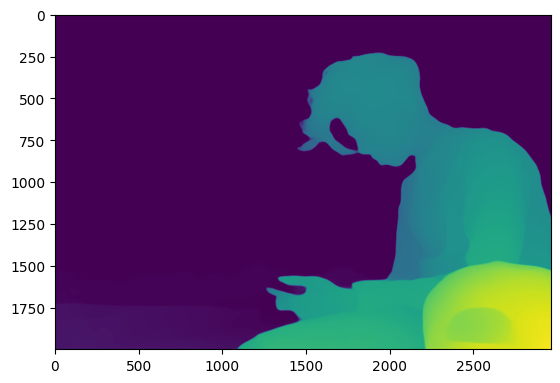

In [40]:
plt.imshow(low_res_depth)
plt.show()


In [43]:
tile_sizes = [[4,4], [8,8]]

filters = []

save_filter_images = False

for tile_size in tile_sizes:

    num_x = tile_size[0]
    num_y = tile_size[1]

    M = im.shape[0]//num_x
    N = im.shape[1]//num_y
    print(num_x,num_y,M,N)

    filter_dict = {}
    filter_dict['right_filter'] = np.zeros((M, N))
    filter_dict['left_filter'] = np.zeros((M, N))
    filter_dict['top_filter'] = np.zeros((M, N))
    filter_dict['bottom_filter'] = np.zeros((M, N))
    filter_dict['top_right_filter'] = np.zeros((M, N))
    filter_dict['top_left_filter'] = np.zeros((M, N))
    filter_dict['bottom_right_filter'] = np.zeros((M, N))
    filter_dict['bottom_left_filter'] = np.zeros((M, N))
    filter_dict['filter'] = np.zeros((M, N))

    for i in tqdm(range(M)):
      for j in range(N):
          x_value = 0.998*np.cos((abs(M/2-i)/M)*np.pi)**2
          y_value = 0.998*np.cos((abs(N/2-j)/N)*np.pi)**2

          if j > N/2:
              filter_dict['right_filter'][i,j] = x_value
          else:
              filter_dict['right_filter'][i,j] = x_value * y_value

          if j < N/2:
              filter_dict['left_filter'][i,j] = x_value
          else:
              filter_dict['left_filter'][i,j] = x_value * y_value

          if i < M/2:
              filter_dict['top_filter'][i,j] = y_value
          else:
              filter_dict['top_filter'][i,j] = x_value * y_value

          if i > M/2:
              filter_dict['bottom_filter'][i,j] = y_value
          else:
              filter_dict['bottom_filter'][i,j] = x_value * y_value

          if j > N/2 and i < M/2:
              filter_dict['top_right_filter'][i,j] = 0.998
          elif j > N/2:
              filter_dict['top_right_filter'][i,j] = x_value
          elif i < M/2:
              filter_dict['top_right_filter'][i,j] = y_value
          else:
              filter_dict['top_right_filter'][i,j] = x_value * y_value

          if j < N/2 and i < M/2:
              filter_dict['top_left_filter'][i,j] = 0.998
          elif j < N/2:
              filter_dict['top_left_filter'][i,j] = x_value
          elif i < M/2:
              filter_dict['top_left_filter'][i,j] = y_value
          else:
              filter_dict['top_left_filter'][i,j] = x_value * y_value

          if j > N/2 and i > M/2:
              filter_dict['bottom_right_filter'][i,j] = 0.998
          elif j > N/2:
              filter_dict['bottom_right_filter'][i,j] = x_value
          elif i > M/2:
              filter_dict['bottom_right_filter'][i,j] = y_value
          else:
              filter_dict['bottom_right_filter'][i,j] = x_value * y_value

          if j < N/2 and i > M/2:
              filter_dict['bottom_left_filter'][i,j] = 0.998
          elif j < N/2:
              filter_dict['bottom_left_filter'][i,j] = x_value
          elif i > M/2:
              filter_dict['bottom_left_filter'][i,j] = y_value
          else:
              filter_dict['bottom_left_filter'][i,j] = x_value * y_value

          filter_dict['filter'][i,j] = x_value * y_value

    filters.append(filter_dict)

    if save_filter_images:
        for filter in list(filter_dict.keys()):
            filter_image = Image.fromarray((filter_dict[filter]*2**16).astype("uint16"))
            filter_image.save(f'mask_{filter}_{num_x}_{num_y}.png')

4 4 500 741


100%|██████████| 500/500 [00:01<00:00, 275.03it/s]


8 8 250 370


100%|██████████| 250/250 [00:00<00:00, 558.77it/s]


In [51]:
compiled_tiles_list = []
print(len(filters))
for i in range(len(filters)):

    num_x = tile_sizes[i][0]
    num_y = tile_sizes[i][1]

    M = im.shape[0]//num_x
    N = im.shape[1]//num_y

    compiled_tiles = np.zeros((im.shape[0], im.shape[1]))

    x_coords = list(range(0,im.shape[0],im.shape[0]//num_x))[:num_x]
    y_coords = list(range(0,im.shape[1],im.shape[1]//num_y))[:num_y]

    x_coords_between = list(range((im.shape[0]//num_x)//2, im.shape[0], im.shape[0]//num_x))[:num_x-1]
    y_coords_between = list(range((im.shape[1]//num_y)//2,im.shape[1],im.shape[1]//num_y))[:num_y-1]

    x_coords_all = x_coords + x_coords_between
    y_coords_all = y_coords + y_coords_between

    shapes_big = []
    shapes_small = []
    
    for x in tqdm(x_coords_all):
        for y in y_coords_all:
            im_infer = im[x:x+M,y:y+N]
            if im_infer.shape == (500, 741, 3):
                shapes_big.append(im_infer.shape)
            elif im_infer.shape == (250, 370, 3):
                shapes_small.append(im_infer.shape)
            inputs = processor(images=im_infer, return_tensors="pt").to(device)
            with torch.no_grad():
                outputs = model(**inputs)
                predicted_depth = outputs.predicted_depth
            predicted_depth = predicted_depth.cpu().numpy()
            scaled_depth = 2**16 - (cv2.resize(np.squeeze((predicted_depth * 255 / np.max(predicted_depth)).astype("uint8"), axis=0), (im_infer.shape[1], im_infer.shape[0]), interpolation=cv2.INTER_CUBIC) - np.min(cv2.resize(np.squeeze((predicted_depth * 255 / np.max(predicted_depth)).astype("uint8"), axis=0), (im.shape[1], im.shape[0]), interpolation=cv2.INTER_CUBIC))) * 2**16 / (np.max(cv2.resize(np.squeeze((predicted_depth * 255 / np.max(predicted_depth)).astype("uint8"), axis=0), (im.shape[1], im.shape[0]), interpolation=cv2.INTER_CUBIC)) - np.min(cv2.resize(np.squeeze((predicted_depth * 255 / np.max(predicted_depth)).astype("uint8"), axis=0), (im.shape[1], im.shape[0]), interpolation=cv2.INTER_CUBIC)))
            print(scaled_depth.shape)
            if y == min(y_coords_all) and x == min(x_coords_all):
                selected_filter = filters[i]['top_left_filter']
            elif y == min(y_coords_all) and x == max(x_coords_all):
                selected_filter = filters[i]['bottom_left_filter']
            elif y == max(y_coords_all) and x == min(x_coords_all):
                selected_filter = filters[i]['top_right_filter']
            elif y == max(y_coords_all) and x == max(x_coords_all):
                selected_filter = filters[i]['bottom_right_filter']
            elif y == min(y_coords_all):
                selected_filter = filters[i]['left_filter']
            elif y == max(y_coords_all):
                selected_filter = filters[i]['right_filter']
            elif x == min(x_coords_all):
                selected_filter = filters[i]['top_filter']
            elif x == max(x_coords_all):
                selected_filter = filters[i]['bottom_filter']
            else:
                selected_filter = filters[i]['filter']
            print(low_res_scaled_depth[x:x+M, y:y+N].shape,"___",scaled_depth.shape, "___",compiled_tiles[x:x+M, y:y+N].shape)
            compiled_tiles[x:x+M, y:y+N] += selected_filter * (np.mean(low_res_scaled_depth[x:x+M, y:y+N]) + np.std(low_res_scaled_depth[x:x+M, y:y+N]) * ((scaled_depth - np.mean(scaled_depth)) /  np.std(scaled_depth)))

    compiled_tiles[compiled_tiles < 0] = 0
    compiled_tiles_list.append(compiled_tiles)



2
7 7


  0%|          | 0/7 [00:00<?, ?it/s]

(500, 741)
(500, 741) ___ (500, 741) ___ (500, 741)
(500, 741)
(500, 741) ___ (500, 741) ___ (500, 741)
(500, 741)
(500, 741) ___ (500, 741) ___ (500, 741)
(500, 741)
(500, 741) ___ (500, 741) ___ (500, 741)
(500, 741)
(500, 741) ___ (500, 741) ___ (500, 741)
(500, 741)
(500, 741) ___ (500, 741) ___ (500, 741)


 14%|█▍        | 1/7 [02:18<13:52, 138.73s/it]

(500, 741)
(500, 741) ___ (500, 741) ___ (500, 741)
(500, 741)
(500, 741) ___ (500, 741) ___ (500, 741)
(500, 741)
(500, 741) ___ (500, 741) ___ (500, 741)
(500, 741)
(500, 741) ___ (500, 741) ___ (500, 741)
(500, 741)
(500, 741) ___ (500, 741) ___ (500, 741)
(500, 741)
(500, 741) ___ (500, 741) ___ (500, 741)
(500, 741)
(500, 741) ___ (500, 741) ___ (500, 741)


 29%|██▊       | 2/7 [04:16<10:32, 126.48s/it]

(500, 741)
(500, 741) ___ (500, 741) ___ (500, 741)
(500, 741)
(500, 741) ___ (500, 741) ___ (500, 741)
(500, 741)
(500, 741) ___ (500, 741) ___ (500, 741)
(500, 741)
(500, 741) ___ (500, 741) ___ (500, 741)
(500, 741)
(500, 741) ___ (500, 741) ___ (500, 741)
(500, 741)
(500, 741) ___ (500, 741) ___ (500, 741)
(500, 741)
(500, 741) ___ (500, 741) ___ (500, 741)


 43%|████▎     | 3/7 [06:16<08:13, 123.28s/it]

(500, 741)
(500, 741) ___ (500, 741) ___ (500, 741)
(500, 741)
(500, 741) ___ (500, 741) ___ (500, 741)
(500, 741)
(500, 741) ___ (500, 741) ___ (500, 741)
(500, 741)
(500, 741) ___ (500, 741) ___ (500, 741)
(500, 741)
(500, 741) ___ (500, 741) ___ (500, 741)
(500, 741)
(500, 741) ___ (500, 741) ___ (500, 741)
(500, 741)
(500, 741) ___ (500, 741) ___ (500, 741)


 57%|█████▋    | 4/7 [08:14<06:03, 121.25s/it]

(500, 741)
(500, 741) ___ (500, 741) ___ (500, 741)
(500, 741)
(500, 741) ___ (500, 741) ___ (500, 741)
(500, 741)
(500, 741) ___ (500, 741) ___ (500, 741)
(500, 741)
(500, 741) ___ (500, 741) ___ (500, 741)
(500, 741)
(500, 741) ___ (500, 741) ___ (500, 741)
(500, 741)
(500, 741) ___ (500, 741) ___ (500, 741)
(500, 741)
(500, 741) ___ (500, 741) ___ (500, 741)


 71%|███████▏  | 5/7 [10:10<03:59, 119.60s/it]

(500, 741)
(500, 741) ___ (500, 741) ___ (500, 741)
(500, 741)
(500, 741) ___ (500, 741) ___ (500, 741)
(500, 741)
(500, 741) ___ (500, 741) ___ (500, 741)
(500, 741)
(500, 741) ___ (500, 741) ___ (500, 741)
(500, 741)
(500, 741) ___ (500, 741) ___ (500, 741)
(500, 741)
(500, 741) ___ (500, 741) ___ (500, 741)
(500, 741)
(500, 741) ___ (500, 741) ___ (500, 741)


 86%|████████▌ | 6/7 [12:11<01:59, 119.78s/it]

(500, 741)
(500, 741) ___ (500, 741) ___ (500, 741)
(500, 741)
(500, 741) ___ (500, 741) ___ (500, 741)
(500, 741)
(500, 741) ___ (500, 741) ___ (500, 741)
(500, 741)
(500, 741) ___ (500, 741) ___ (500, 741)
(500, 741)
(500, 741) ___ (500, 741) ___ (500, 741)
(500, 741)
(500, 741) ___ (500, 741) ___ (500, 741)
(500, 741)
(500, 741) ___ (500, 741) ___ (500, 741)


100%|██████████| 7/7 [14:24<00:00, 123.49s/it]


(500, 741)
(500, 741) ___ (500, 741) ___ (500, 741)
15 15


  0%|          | 0/15 [00:00<?, ?it/s]

(250, 370)
(250, 370) ___ (250, 370) ___ (250, 370)
(250, 370)
(250, 370) ___ (250, 370) ___ (250, 370)
(250, 370)
(250, 370) ___ (250, 370) ___ (250, 370)
(250, 370)
(250, 370) ___ (250, 370) ___ (250, 370)
(250, 370)
(250, 370) ___ (250, 370) ___ (250, 370)
(250, 370)
(250, 370) ___ (250, 370) ___ (250, 370)
(250, 370)
(250, 370) ___ (250, 370) ___ (250, 370)
(250, 370)
(250, 370) ___ (250, 370) ___ (250, 370)
(250, 370)
(250, 370) ___ (250, 370) ___ (250, 370)
(250, 370)
(250, 370) ___ (250, 370) ___ (250, 370)
(250, 370)
(250, 370) ___ (250, 370) ___ (250, 370)
(250, 370)
(250, 370) ___ (250, 370) ___ (250, 370)
(250, 370)
(250, 370) ___ (250, 370) ___ (250, 370)
(250, 370)
(250, 370) ___ (250, 370) ___ (250, 370)


  7%|▋         | 1/15 [01:25<19:51, 85.11s/it]

(250, 370)
(250, 370) ___ (250, 370) ___ (250, 370)
(250, 370)
(250, 370) ___ (250, 370) ___ (250, 370)
(250, 370)
(250, 370) ___ (250, 370) ___ (250, 370)
(250, 370)
(250, 370) ___ (250, 370) ___ (250, 370)
(250, 370)
(250, 370) ___ (250, 370) ___ (250, 370)
(250, 370)
(250, 370) ___ (250, 370) ___ (250, 370)
(250, 370)
(250, 370) ___ (250, 370) ___ (250, 370)
(250, 370)
(250, 370) ___ (250, 370) ___ (250, 370)
(250, 370)
(250, 370) ___ (250, 370) ___ (250, 370)
(250, 370)
(250, 370) ___ (250, 370) ___ (250, 370)
(250, 370)
(250, 370) ___ (250, 370) ___ (250, 370)
(250, 370)
(250, 370) ___ (250, 370) ___ (250, 370)
(250, 370)
(250, 370) ___ (250, 370) ___ (250, 370)
(250, 370)
(250, 370) ___ (250, 370) ___ (250, 370)
(250, 370)
(250, 370) ___ (250, 370) ___ (250, 370)


 13%|█▎        | 2/15 [02:59<19:35, 90.42s/it]

(250, 370)
(250, 370) ___ (250, 370) ___ (250, 370)
(250, 370)
(250, 370) ___ (250, 370) ___ (250, 370)
(250, 370)
(250, 370) ___ (250, 370) ___ (250, 370)
(250, 370)
(250, 370) ___ (250, 370) ___ (250, 370)
(250, 370)
(250, 370) ___ (250, 370) ___ (250, 370)
(250, 370)
(250, 370) ___ (250, 370) ___ (250, 370)
(250, 370)
(250, 370) ___ (250, 370) ___ (250, 370)
(250, 370)
(250, 370) ___ (250, 370) ___ (250, 370)
(250, 370)
(250, 370) ___ (250, 370) ___ (250, 370)
(250, 370)
(250, 370) ___ (250, 370) ___ (250, 370)
(250, 370)
(250, 370) ___ (250, 370) ___ (250, 370)
(250, 370)
(250, 370) ___ (250, 370) ___ (250, 370)
(250, 370)
(250, 370) ___ (250, 370) ___ (250, 370)
(250, 370)
(250, 370) ___ (250, 370) ___ (250, 370)
(250, 370)
(250, 370) ___ (250, 370) ___ (250, 370)


 20%|██        | 3/15 [04:38<18:54, 94.57s/it]

(250, 370)
(250, 370) ___ (250, 370) ___ (250, 370)
(250, 370)
(250, 370) ___ (250, 370) ___ (250, 370)
(250, 370)
(250, 370) ___ (250, 370) ___ (250, 370)
(250, 370)
(250, 370) ___ (250, 370) ___ (250, 370)
(250, 370)
(250, 370) ___ (250, 370) ___ (250, 370)
(250, 370)
(250, 370) ___ (250, 370) ___ (250, 370)
(250, 370)
(250, 370) ___ (250, 370) ___ (250, 370)
(250, 370)
(250, 370) ___ (250, 370) ___ (250, 370)
(250, 370)
(250, 370) ___ (250, 370) ___ (250, 370)
(250, 370)
(250, 370) ___ (250, 370) ___ (250, 370)
(250, 370)
(250, 370) ___ (250, 370) ___ (250, 370)
(250, 370)
(250, 370) ___ (250, 370) ___ (250, 370)
(250, 370)
(250, 370) ___ (250, 370) ___ (250, 370)
(250, 370)
(250, 370) ___ (250, 370) ___ (250, 370)
(250, 370)
(250, 370) ___ (250, 370) ___ (250, 370)


 27%|██▋       | 4/15 [06:11<17:14, 94.01s/it]

(250, 370)
(250, 370) ___ (250, 370) ___ (250, 370)
(250, 370)
(250, 370) ___ (250, 370) ___ (250, 370)
(250, 370)
(250, 370) ___ (250, 370) ___ (250, 370)
(250, 370)
(250, 370) ___ (250, 370) ___ (250, 370)
(250, 370)
(250, 370) ___ (250, 370) ___ (250, 370)
(250, 370)
(250, 370) ___ (250, 370) ___ (250, 370)
(250, 370)
(250, 370) ___ (250, 370) ___ (250, 370)
(250, 370)
(250, 370) ___ (250, 370) ___ (250, 370)
(250, 370)
(250, 370) ___ (250, 370) ___ (250, 370)
(250, 370)
(250, 370) ___ (250, 370) ___ (250, 370)
(250, 370)
(250, 370) ___ (250, 370) ___ (250, 370)
(250, 370)
(250, 370) ___ (250, 370) ___ (250, 370)
(250, 370)
(250, 370) ___ (250, 370) ___ (250, 370)
(250, 370)
(250, 370) ___ (250, 370) ___ (250, 370)
(250, 370)
(250, 370) ___ (250, 370) ___ (250, 370)


 33%|███▎      | 5/15 [07:39<15:16, 91.61s/it]

(250, 370)
(250, 370) ___ (250, 370) ___ (250, 370)
(250, 370)
(250, 370) ___ (250, 370) ___ (250, 370)
(250, 370)
(250, 370) ___ (250, 370) ___ (250, 370)
(250, 370)
(250, 370) ___ (250, 370) ___ (250, 370)
(250, 370)
(250, 370) ___ (250, 370) ___ (250, 370)
(250, 370)
(250, 370) ___ (250, 370) ___ (250, 370)
(250, 370)
(250, 370) ___ (250, 370) ___ (250, 370)
(250, 370)
(250, 370) ___ (250, 370) ___ (250, 370)
(250, 370)
(250, 370) ___ (250, 370) ___ (250, 370)
(250, 370)
(250, 370) ___ (250, 370) ___ (250, 370)
(250, 370)
(250, 370) ___ (250, 370) ___ (250, 370)
(250, 370)
(250, 370) ___ (250, 370) ___ (250, 370)
(250, 370)
(250, 370) ___ (250, 370) ___ (250, 370)
(250, 370)
(250, 370) ___ (250, 370) ___ (250, 370)
(250, 370)
(250, 370) ___ (250, 370) ___ (250, 370)


 40%|████      | 6/15 [09:03<13:22, 89.22s/it]

(250, 370)
(250, 370) ___ (250, 370) ___ (250, 370)
(250, 370)
(250, 370) ___ (250, 370) ___ (250, 370)
(250, 370)
(250, 370) ___ (250, 370) ___ (250, 370)
(250, 370)
(250, 370) ___ (250, 370) ___ (250, 370)
(250, 370)
(250, 370) ___ (250, 370) ___ (250, 370)
(250, 370)
(250, 370) ___ (250, 370) ___ (250, 370)
(250, 370)
(250, 370) ___ (250, 370) ___ (250, 370)
(250, 370)
(250, 370) ___ (250, 370) ___ (250, 370)
(250, 370)
(250, 370) ___ (250, 370) ___ (250, 370)
(250, 370)
(250, 370) ___ (250, 370) ___ (250, 370)
(250, 370)
(250, 370) ___ (250, 370) ___ (250, 370)
(250, 370)
(250, 370) ___ (250, 370) ___ (250, 370)
(250, 370)
(250, 370) ___ (250, 370) ___ (250, 370)
(250, 370)
(250, 370) ___ (250, 370) ___ (250, 370)
(250, 370)
(250, 370) ___ (250, 370) ___ (250, 370)


 47%|████▋     | 7/15 [10:29<11:43, 87.90s/it]

(250, 370)
(250, 370) ___ (250, 370) ___ (250, 370)
(250, 370)
(250, 370) ___ (250, 370) ___ (250, 370)
(250, 370)
(250, 370) ___ (250, 370) ___ (250, 370)
(250, 370)
(250, 370) ___ (250, 370) ___ (250, 370)
(250, 370)
(250, 370) ___ (250, 370) ___ (250, 370)
(250, 370)
(250, 370) ___ (250, 370) ___ (250, 370)
(250, 370)
(250, 370) ___ (250, 370) ___ (250, 370)
(250, 370)
(250, 370) ___ (250, 370) ___ (250, 370)
(250, 370)
(250, 370) ___ (250, 370) ___ (250, 370)
(250, 370)
(250, 370) ___ (250, 370) ___ (250, 370)
(250, 370)
(250, 370) ___ (250, 370) ___ (250, 370)
(250, 370)
(250, 370) ___ (250, 370) ___ (250, 370)
(250, 370)
(250, 370) ___ (250, 370) ___ (250, 370)
(250, 370)
(250, 370) ___ (250, 370) ___ (250, 370)
(250, 370)
(250, 370) ___ (250, 370) ___ (250, 370)


 53%|█████▎    | 8/15 [12:00<10:24, 89.15s/it]

(250, 370)
(250, 370) ___ (250, 370) ___ (250, 370)
(250, 370)
(250, 370) ___ (250, 370) ___ (250, 370)
(250, 370)
(250, 370) ___ (250, 370) ___ (250, 370)
(250, 370)
(250, 370) ___ (250, 370) ___ (250, 370)
(250, 370)
(250, 370) ___ (250, 370) ___ (250, 370)
(250, 370)
(250, 370) ___ (250, 370) ___ (250, 370)
(250, 370)
(250, 370) ___ (250, 370) ___ (250, 370)
(250, 370)
(250, 370) ___ (250, 370) ___ (250, 370)
(250, 370)
(250, 370) ___ (250, 370) ___ (250, 370)
(250, 370)
(250, 370) ___ (250, 370) ___ (250, 370)
(250, 370)
(250, 370) ___ (250, 370) ___ (250, 370)
(250, 370)
(250, 370) ___ (250, 370) ___ (250, 370)
(250, 370)
(250, 370) ___ (250, 370) ___ (250, 370)
(250, 370)
(250, 370) ___ (250, 370) ___ (250, 370)
(250, 370)
(250, 370) ___ (250, 370) ___ (250, 370)


 60%|██████    | 9/15 [13:33<09:00, 90.13s/it]

(250, 370)
(250, 370) ___ (250, 370) ___ (250, 370)
(250, 370)
(250, 370) ___ (250, 370) ___ (250, 370)
(250, 370)
(250, 370) ___ (250, 370) ___ (250, 370)
(250, 370)
(250, 370) ___ (250, 370) ___ (250, 370)
(250, 370)
(250, 370) ___ (250, 370) ___ (250, 370)
(250, 370)
(250, 370) ___ (250, 370) ___ (250, 370)
(250, 370)
(250, 370) ___ (250, 370) ___ (250, 370)
(250, 370)
(250, 370) ___ (250, 370) ___ (250, 370)
(250, 370)
(250, 370) ___ (250, 370) ___ (250, 370)
(250, 370)
(250, 370) ___ (250, 370) ___ (250, 370)
(250, 370)
(250, 370) ___ (250, 370) ___ (250, 370)
(250, 370)
(250, 370) ___ (250, 370) ___ (250, 370)
(250, 370)
(250, 370) ___ (250, 370) ___ (250, 370)
(250, 370)
(250, 370) ___ (250, 370) ___ (250, 370)
(250, 370)
(250, 370) ___ (250, 370) ___ (250, 370)


 67%|██████▋   | 10/15 [15:11<07:44, 92.82s/it]

(250, 370)
(250, 370) ___ (250, 370) ___ (250, 370)
(250, 370)
(250, 370) ___ (250, 370) ___ (250, 370)
(250, 370)
(250, 370) ___ (250, 370) ___ (250, 370)
(250, 370)
(250, 370) ___ (250, 370) ___ (250, 370)
(250, 370)
(250, 370) ___ (250, 370) ___ (250, 370)
(250, 370)
(250, 370) ___ (250, 370) ___ (250, 370)
(250, 370)
(250, 370) ___ (250, 370) ___ (250, 370)
(250, 370)
(250, 370) ___ (250, 370) ___ (250, 370)
(250, 370)
(250, 370) ___ (250, 370) ___ (250, 370)
(250, 370)
(250, 370) ___ (250, 370) ___ (250, 370)
(250, 370)
(250, 370) ___ (250, 370) ___ (250, 370)
(250, 370)
(250, 370) ___ (250, 370) ___ (250, 370)
(250, 370)
(250, 370) ___ (250, 370) ___ (250, 370)
(250, 370)
(250, 370) ___ (250, 370) ___ (250, 370)
(250, 370)
(250, 370) ___ (250, 370) ___ (250, 370)


 73%|███████▎  | 11/15 [16:41<06:07, 91.76s/it]

(250, 370)
(250, 370) ___ (250, 370) ___ (250, 370)
(250, 370)
(250, 370) ___ (250, 370) ___ (250, 370)
(250, 370)
(250, 370) ___ (250, 370) ___ (250, 370)
(250, 370)
(250, 370) ___ (250, 370) ___ (250, 370)
(250, 370)
(250, 370) ___ (250, 370) ___ (250, 370)
(250, 370)
(250, 370) ___ (250, 370) ___ (250, 370)
(250, 370)
(250, 370) ___ (250, 370) ___ (250, 370)
(250, 370)
(250, 370) ___ (250, 370) ___ (250, 370)
(250, 370)
(250, 370) ___ (250, 370) ___ (250, 370)
(250, 370)
(250, 370) ___ (250, 370) ___ (250, 370)
(250, 370)
(250, 370) ___ (250, 370) ___ (250, 370)
(250, 370)
(250, 370) ___ (250, 370) ___ (250, 370)
(250, 370)
(250, 370) ___ (250, 370) ___ (250, 370)
(250, 370)
(250, 370) ___ (250, 370) ___ (250, 370)
(250, 370)
(250, 370) ___ (250, 370) ___ (250, 370)


 80%|████████  | 12/15 [18:06<04:29, 89.88s/it]

(250, 370)
(250, 370) ___ (250, 370) ___ (250, 370)
(250, 370)
(250, 370) ___ (250, 370) ___ (250, 370)
(250, 370)
(250, 370) ___ (250, 370) ___ (250, 370)
(250, 370)
(250, 370) ___ (250, 370) ___ (250, 370)
(250, 370)
(250, 370) ___ (250, 370) ___ (250, 370)
(250, 370)
(250, 370) ___ (250, 370) ___ (250, 370)
(250, 370)
(250, 370) ___ (250, 370) ___ (250, 370)
(250, 370)
(250, 370) ___ (250, 370) ___ (250, 370)
(250, 370)
(250, 370) ___ (250, 370) ___ (250, 370)
(250, 370)
(250, 370) ___ (250, 370) ___ (250, 370)
(250, 370)
(250, 370) ___ (250, 370) ___ (250, 370)
(250, 370)
(250, 370) ___ (250, 370) ___ (250, 370)
(250, 370)
(250, 370) ___ (250, 370) ___ (250, 370)
(250, 370)
(250, 370) ___ (250, 370) ___ (250, 370)
(250, 370)
(250, 370) ___ (250, 370) ___ (250, 370)


 87%|████████▋ | 13/15 [19:31<02:56, 88.19s/it]

(250, 370)
(250, 370) ___ (250, 370) ___ (250, 370)
(250, 370)
(250, 370) ___ (250, 370) ___ (250, 370)
(250, 370)
(250, 370) ___ (250, 370) ___ (250, 370)
(250, 370)
(250, 370) ___ (250, 370) ___ (250, 370)
(250, 370)
(250, 370) ___ (250, 370) ___ (250, 370)
(250, 370)
(250, 370) ___ (250, 370) ___ (250, 370)
(250, 370)
(250, 370) ___ (250, 370) ___ (250, 370)
(250, 370)
(250, 370) ___ (250, 370) ___ (250, 370)
(250, 370)
(250, 370) ___ (250, 370) ___ (250, 370)
(250, 370)
(250, 370) ___ (250, 370) ___ (250, 370)
(250, 370)
(250, 370) ___ (250, 370) ___ (250, 370)
(250, 370)
(250, 370) ___ (250, 370) ___ (250, 370)
(250, 370)
(250, 370) ___ (250, 370) ___ (250, 370)
(250, 370)
(250, 370) ___ (250, 370) ___ (250, 370)
(250, 370)
(250, 370) ___ (250, 370) ___ (250, 370)


 93%|█████████▎| 14/15 [20:58<01:27, 87.96s/it]

(250, 370)
(250, 370) ___ (250, 370) ___ (250, 370)
(250, 370)
(250, 370) ___ (250, 370) ___ (250, 370)
(250, 370)
(250, 370) ___ (250, 370) ___ (250, 370)
(250, 370)
(250, 370) ___ (250, 370) ___ (250, 370)
(250, 370)
(250, 370) ___ (250, 370) ___ (250, 370)
(250, 370)
(250, 370) ___ (250, 370) ___ (250, 370)
(250, 370)
(250, 370) ___ (250, 370) ___ (250, 370)
(250, 370)
(250, 370) ___ (250, 370) ___ (250, 370)
(250, 370)
(250, 370) ___ (250, 370) ___ (250, 370)
(250, 370)
(250, 370) ___ (250, 370) ___ (250, 370)
(250, 370)
(250, 370) ___ (250, 370) ___ (250, 370)
(250, 370)
(250, 370) ___ (250, 370) ___ (250, 370)
(250, 370)
(250, 370) ___ (250, 370) ___ (250, 370)
(250, 370)
(250, 370) ___ (250, 370) ___ (250, 370)
(250, 370)
(250, 370) ___ (250, 370) ___ (250, 370)


100%|██████████| 15/15 [22:26<00:00, 89.77s/it]

(250, 370)
(250, 370) ___ (250, 370) ___ (250, 370)


In [52]:
# c = 0
# d = 0
# for i in shapes:
#     if i == (250, 370, 3):
#         c += 1
#     else:
#         d += 1
# print(d)
print(len(shapes_big))
print(len(shapes_small))
    

0
225


In [11]:
from scipy.ndimage import gaussian_filter

grey_im = np.mean(im,axis=2)
tiles_blur = gaussian_filter(grey_im, sigma=20)
tiles_difference = tiles_blur - grey_im

tiles_difference = tiles_difference / np.max(tiles_difference)

tiles_difference = gaussian_filter(tiles_difference, sigma=40)

tiles_difference *= 5

tiles_difference = np.clip(tiles_difference, 0, 0.999)

combined_result = (tiles_difference * compiled_tiles_list[1] + (1-tiles_difference) * ((compiled_tiles_list[0] + low_res_scaled_depth)/2))/(2)

combined_image = (2**16 * 0.999* combined_result / np.max(combined_result)).astype("uint16")

In [12]:
print(combined_image.shape)
print(np.max(combined_image),np.min(combined_image))
combined_image = cv2.normalize(combined_image, None, 0, 255, cv2.NORM_MINMAX)
print(np.max(combined_image),np.min(combined_image))
hr_image_np = combined_image

(2000, 2964)
65470 0
255 0


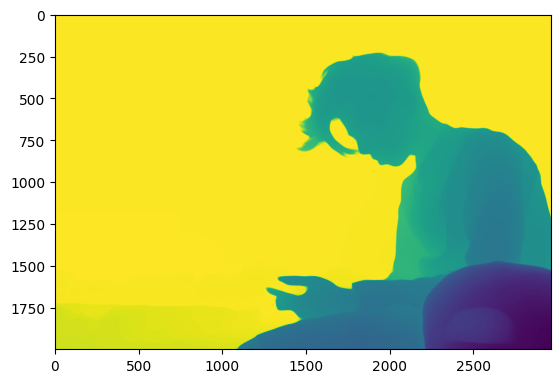

In [13]:
plt.imshow(hr_image_np)
plt.show()

In [16]:
print(hr_image_np.shape[1],hr_image_np.shape[0])

2964 2000


(2044.0, 740.0)
2019 2070 715 766


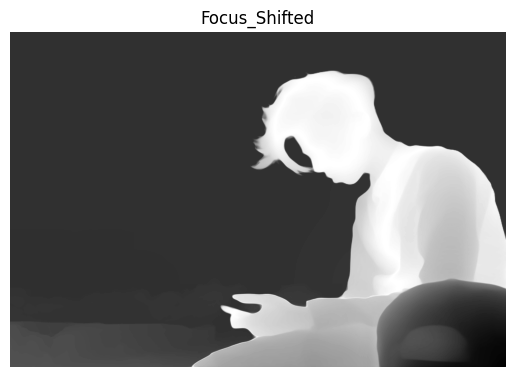

In [24]:
def adjust_depth_map_with_focus(depth_map, focus_point, blur_factor):
    region_size = blur_factor  # This gives a 3x3 region
    half_region = region_size // 2

    # Define Focus Region Pointer
    x_start = int(max(focus_point[0] - half_region, 0))
    x_end = int(min(focus_point[0] + half_region + 1, depth_map.shape[1]))
    y_start = int(max(focus_point[1] - half_region, 0))
    y_end = int(min(focus_point[1] + half_region + 1, depth_map.shape[0]))

    print(x_start,x_end,y_start,y_end)

    focus_region = depth_map[y_start:y_end, x_start:x_end]

    # Calculate average of that Focus Region
    focus_depth = np.mean(focus_region)

    # That fucking euclidian distance
    dist_map = (np.sqrt( (depth_map - focus_depth)**2))

    dist_map_normalized = (dist_map - np.min(dist_map)) / (np.max(dist_map) - np.min(dist_map))

    dist_map_normalized_inverted = 1 - dist_map_normalized

    return dist_map_normalized_inverted


focus_point = (hr_image_np.shape[1] // 1.45, hr_image_np.shape[0] // 2.7)  # Example: focus at the center
print(focus_point)
blur_factor = 50.0
adjusted_depth_map_inverted = adjust_depth_map_with_focus(hr_image_np, focus_point, blur_factor)

plt.imshow(adjusted_depth_map_inverted, cmap='gray')
plt.title('Focus_Shifted')
plt.axis('off') 
plt.show()


Successfully resized Original image to 4k
Successfully resized RealESRGAN output image to 4k


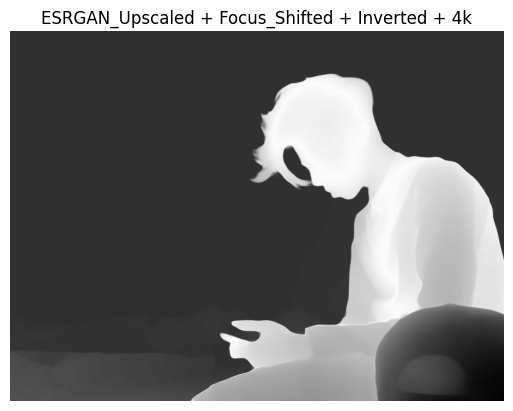

True

In [25]:
def resize_to_4k(img):
    height = img.shape[0]
    width = img.shape[1]
    my_height = 0
    my_width = 0
    if height > width:
        my_height = 4000
        my_width = int(my_height/(height/width))
    else:
        my_width = 4000
        my_height = int(my_width/(width/height))
    return cv2.resize(img, (my_width, my_height), interpolation=cv2.INTER_CUBIC)

image_cv_4k = resize_to_4k(image)
print("Successfully resized Original image to 4k")

adjusted_depth_map_inverted_4k = cv2.resize(adjusted_depth_map_inverted, (image_cv_4k.shape[1], image_cv_4k.shape[0]), interpolation=cv2.INTER_CUBIC).astype(np.float32)
print("Successfully resized RealESRGAN output image to 4k")

plt.imshow(adjusted_depth_map_inverted_4k, cmap='gray')
plt.title('ESRGAN_Upscaled + Focus_Shifted + Inverted + 4k')
plt.axis('off')  # Hide the axis
plt.show()
cv2.imwrite("output/adjusted_depth_map_inverted_4k.jpg",adjusted_depth_map_inverted_4k)



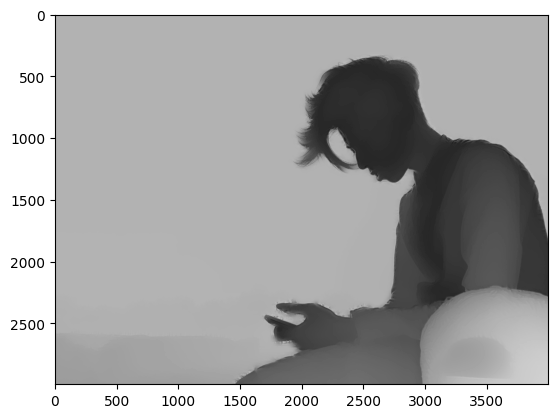

True

In [26]:

def laplacian_of_gaussian_edge_detection(image, ksize=5):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (ksize, ksize), 0)
    edges = cv2.Laplacian(blur, cv2.CV_16S, ksize=ksize)
    abs_edges = cv2.convertScaleAbs(edges)
    return abs_edges

def apply_guided_filter(image, depth_map, radius=12, eps=0.9, iterations=90):
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    guided_depth = depth_map
    for i in range(iterations):
        guided_depth = guidedFilter(guide=gray_image, src=guided_depth, radius=radius, eps=eps)
    return guided_depth

edges = laplacian_of_gaussian_edge_detection(image_cv_4k, ksize=7)
_, binary_edges = cv2.threshold(edges, 50, 150, cv2.THRESH_BINARY)
edge_mask = binary_edges > 0
refined_depth = np.where(edge_mask, adjusted_depth_map_inverted_4k, adjusted_depth_map_inverted_4k)

adjusted_depth_map_inverted_4k_refined = apply_guided_filter(image_cv_4k, refined_depth, radius=8, eps=0.1, iterations=12)
adjusted_depth_map_inverted_4k_refined = cv2.normalize(adjusted_depth_map_inverted_4k_refined, None, 0, 1, cv2.NORM_MINMAX)
adjusted_depth_map_4k_refined = np.max(adjusted_depth_map_inverted_4k_refined) - adjusted_depth_map_inverted_4k_refined
adjusted_depth_map_4k_refined = cv2.normalize(adjusted_depth_map_4k_refined, None, 0, 255, cv2.NORM_MINMAX)
plt.imshow(adjusted_depth_map_4k_refined, cmap = "gray")
plt.show()
cv2.imwrite("output/adjusted_depth_map_4k_refined.jpg",adjusted_depth_map_4k_refined)


In [27]:
print(np.min(adjusted_depth_map_4k_refined),np.max(adjusted_depth_map_4k_refined))

0.0 255.0


In [ ]:
# result = lens_blur_with_depth_map(
#    image_cv_4k,
#    depth_map=np.stack([adjusted_depth_map_4k_refined] * 3, axis=-1).astype(np.uint8),
#    components=5,
#    exposure_gamma=5,
#    num_layers=2,
#    min_blur=1,
#    max_blur=60
# )
# image = cv2.cvtColor(result, cv2.COLOR_BGR2RGB)
# plt.imshow(image)
# plt.show()
# cv2.imwrite("output/final_output.jpg",result)

In [28]:
print(np.min(adjusted_depth_map_inverted_4k),np.max(adjusted_depth_map_inverted_4k))
adjusted_depth_map_inverted_4k = cv2.normalize(adjusted_depth_map_inverted_4k, None, 0, 255, cv2.NORM_MINMAX)
adjusted_depth_map_4k = np.max(adjusted_depth_map_inverted_4k) - adjusted_depth_map_inverted_4k

print(np.min(adjusted_depth_map_4k),np.max(adjusted_depth_map_4k))
adjusted_depth_map_4k = cv2.normalize(adjusted_depth_map_4k, None, 0.3, 255, cv2.NORM_MINMAX)
print(np.min(adjusted_depth_map_4k),np.max(adjusted_depth_map_4k))



-0.0030542396 1.0173326
0.0 255.0
0.3 255.0


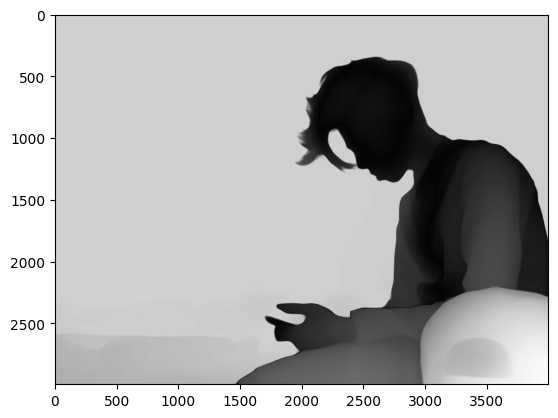

True

In [29]:
plt.imshow(adjusted_depth_map_4k, cmap = "gray")
plt.show()
cv2.imwrite("output/adjusted_depth_map_4k.jpg",adjusted_depth_map_4k)

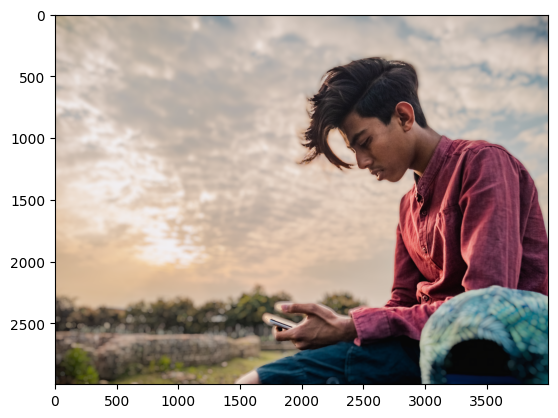

True

In [32]:
result = lens_blur_with_depth_map(
   image_cv_4k,
   depth_map=np.stack([adjusted_depth_map_4k] * 3, axis=-1).astype(np.uint8),
   components=5,
   exposure_gamma=5,
   num_layers=10,
   min_blur=1,
   max_blur=30
)
image = cv2.cvtColor(result, cv2.COLOR_BGR2RGB)
plt.imshow(image)
plt.show()
cv2.imwrite("output/final_output.jpg",result)

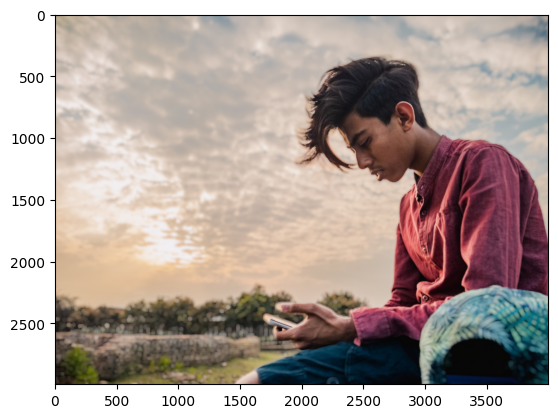

True

In [31]:
result = lens_blur_with_depth_map(
   image_cv_4k,
   depth_map=np.stack([adjusted_depth_map_4k_refined] * 3, axis=-1).astype(np.uint8),
   components=5,
   exposure_gamma=5,
   num_layers=15,
   min_blur=1,
   max_blur=25
)
image = cv2.cvtColor(result, cv2.COLOR_BGR2RGB)
plt.imshow(image)
plt.show()
cv2.imwrite("output/final_output2.jpg",result)